<a href="https://colab.research.google.com/github/mohripan/Image-Deraining/blob/main/Deraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%%shell
cp '/content/gdrive/My Drive/KaggleAPI/kaggle.json' kaggle.json
pip install -q kaggle
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d harshdeepsinghpruthi/deraindataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
deraindataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q /content/deraindataset.zip

replace DeRain-Dataset/CLEAR_val/input_1535201266154233.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
# Import the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import shutil

from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import to_tensor, to_pil_image

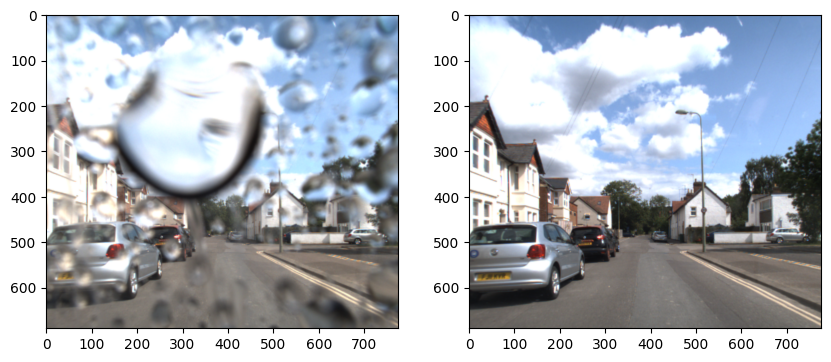

In [5]:
# Set paths
root_dir = '/content/DeRain-Dataset'
train_a = os.path.join(root_dir, 'trainA')
train_b = os.path.join(root_dir, 'trainB')

# Put the paths into a list
images_input = sorted([os.path.join(train_a, f) for f in os.listdir(train_a)])
images_output = sorted([os.path.join(train_b, f) for f in os.listdir(train_b)])

# Choose the image we want to visualize
chose_img = 2
image_input = Image.open(images_input[chose_img])
image_input = np.array(image_input)
image_output = Image.open(images_output[chose_img])
image_output = np.array(image_output)

# Visualize the image
fig, ax = plt.subplots(1, 2, figsize = (10, 8))
ax[0].imshow(image_input)
ax[1].imshow(image_output)
plt.show()

In [6]:
# Create a class for DerainDataset
class DerainDataset(Dataset):
    def __init__(self, input_paths, output_paths, transform = None):
        self.input_paths = input_paths
        self.output_paths = output_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.input_paths)
    
    def __getitem__(self, index):
        input_image = Image.open(self.input_paths[index]).convert('RGB')
        output_image = Image.open(self.output_paths[index]).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)
            
        sample = {'input': input_image, 'output': output_image}
        
        return sample

In [7]:
# # Compute the mean and std for the datasets
# def compute_mean_std(images):
#     all_images = []
#     for img_path in images:
#         img = Image.open(img_path)
#         img = np.array(img) / 255.0  # Scale pixel values to [0, 1]
#         all_images.append(img)
    
#     all_images = np.stack(all_images, axis=0)
#     mean = np.mean(all_images, axis=(0, 1, 2))
#     std = np.std(all_images, axis=(0, 1, 2))
#     return mean, std

# # Set paths
# root_dir = '/content/DeRain-Dataset'
# train_a = os.path.join(root_dir, 'trainA')
# train_b = os.path.join(root_dir, 'trainB')

# # Put the paths into a list
# images_input = sorted([os.path.join(train_a, f) for f in os.listdir(train_a)])
# images_output = sorted([os.path.join(train_b, f) for f in os.listdir(train_b)])

# # Calculate the mean and standard deviation for your dataset
# mean, std = compute_mean_std(images_input + images_output)
# print(mean)
# print(std)

In [8]:
# Define the transformation for the training dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the transformation for the validation dataset
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Set paths
root_dir = '/content/DeRain-Dataset'
train_a = os.path.join(root_dir, 'trainA')
train_b = os.path.join(root_dir, 'trainB')

# Put the paths into a list
images_input = sorted([os.path.join(train_a, f) for f in os.listdir(train_a)])
images_output = sorted([os.path.join(train_b, f) for f in os.listdir(train_b)])

# Initialize the dataset
derain_dataset = DerainDataset(images_input, images_output)

# Define the size of train and validation sets
train_size = int(0.8 * len(derain_dataset))
val_size = len(derain_dataset) - train_size

# Split the data into train and validation sets
train_dataset, val_dataset = random_split(derain_dataset, [train_size, val_size])

# Apply the transformations to the train and validation datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Define DataLoader parameters
batch_size = 32
num_workers = 2

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

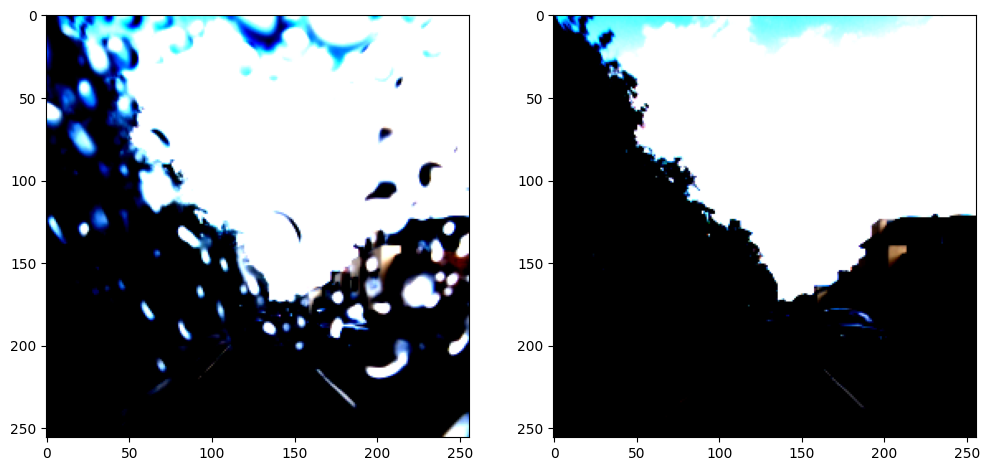

In [10]:
# Try to visualize the transform image
batch = next(iter(train_loader))
image_input = batch['input'][0]
image_input = image_input.permute(1, 2, 0).numpy()

image_output = batch['output'][0]
image_output = image_output.permute(1, 2, 0).numpy()

# Visualize the image
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].imshow(image_input)
ax[1].imshow(image_output)
plt.show()

In [11]:
# Create a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        x = x + residual
        x = self.relu(x)
        return x

# Create a modified UNet with residual block
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            ResidualBlock(in_channels, 64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.middle = ResidualBlock(64, 128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128 + 64, 64, kernel_size=2, stride=2), # Updated number of input channels
            ResidualBlock(64, 64)
        )

        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc = self.encoder(x)
        middle = self.middle(enc)
        dec = self.decoder(torch.cat([middle, enc], 1))
        out = self.output_conv(dec)
        return out

In [14]:
# Save the model
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

#Load the model
def load_model(model, filepath, device):
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    model.eval()

In [12]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the U-Net model with residual blocks
model = UNet(in_channels=3, out_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Train the model
num_epochs = 120

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for training in train_loader:
        inputs = training['input'].to(device)
        targets = training['output'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    
    # Evaluate the model on the validation set
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for validating in val_loader:
            inputs = validating['input'].to(device)
            targets = validating['output'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/120, Train Loss: 0.8567, Val Loss: 0.6979
Epoch 2/120, Train Loss: 0.6423, Val Loss: 0.6148
Epoch 3/120, Train Loss: 0.5668, Val Loss: 0.5822
Epoch 4/120, Train Loss: 0.5264, Val Loss: 0.5305
Epoch 5/120, Train Loss: 0.5005, Val Loss: 0.4919
Epoch 6/120, Train Loss: 0.4770, Val Loss: 0.4914
Epoch 7/120, Train Loss: 0.4589, Val Loss: 0.4600
Epoch 8/120, Train Loss: 0.4566, Val Loss: 0.4593
Epoch 9/120, Train Loss: 0.4357, Val Loss: 0.4435
Epoch 10/120, Train Loss: 0.4337, Val Loss: 0.4538
Epoch 11/120, Train Loss: 0.4230, Val Loss: 0.4429
Epoch 12/120, Train Loss: 0.4229, Val Loss: 0.4313
Epoch 13/120, Train Loss: 0.4147, Val Loss: 0.4319
Epoch 14/120, Train Loss: 0.4015, Val Loss: 0.4138
Epoch 15/120, Train Loss: 0.3994, Val Loss: 0.4074
Epoch 16/120, Train Loss: 0.4002, Val Loss: 0.4144
Epoch 17/120, Train Loss: 0.3912, Val Loss: 0.4284
Epoch 18/120, Train Loss: 0.3894, Val Loss: 0.4173
Epoch 19/120, Train Loss: 0.3896, Val Loss: 0.4103
Epoch 20/120, Train Loss: 0.3813, Val Lo

KeyboardInterrupt: ignored

In [ ]:
# Load and preprocess the input image
input_image_path = "/content/DeRain-Dataset/testA/input_1535201278507228.png"
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (256, 256))

# Convert the input image to a PyTorch tensor and send it to the device
input_tensor = to_tensor(input_image).unsqueeze(0).to(device)

# Pass the input tensor through the model
with torch.no_grad():
    output_tensor = model(input_tensor)

# Postprocess the model's output
output_image = output_tensor.squeeze(0).cpu()
output_image = to_pil_image(output_image)

# Visualize the input and output images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(output_image)
axes[1].set_title("Output Image")
axes[1].axis("off")

plt.show()